In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('flukaRunsTyped.csv', dtype='float64')

In [69]:
energy = 10
data = df.to_numpy()
indices = []
for i in range(data.shape[0]):
    if (data[i,500] == energy):
        indices.append(i)
data = data[indices]

In [70]:
trainRatio = 0.8
# x is the tracklength in each bin
# y is the class label
xfull = data[:,:200]
yfull = data[:,501:507]
# decode the one hot encoded labels
yfull = np.array([list(yfull[i]).index(1) for i in range(yfull.shape[0])])
xtrain, xtest, ytrain, ytest  = train_test_split(
    xfull, yfull, train_size=trainRatio, 
    stratify=yfull, shuffle=True, random_state = 3)

In [78]:
in_size = xtrain.shape[1]
numEpochs = 100
batchSize = 80

model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_size,)),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(6,activation=None)
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.load_weights('./modelEnergyClassifierWeights')

In [79]:
model.fit(xtrain, ytrain, epochs=numEpochs, batch_size=batchSize, shuffle=True)

Epoch 1/100
60/60 [==============================] - 0s 2ms/step - loss: 1.3240 - accuracy: 0.4173
Epoch 2/100
60/60 [==============================] - 0s 2ms/step - loss: 1.3118 - accuracy: 0.4177
Epoch 3/100
60/60 [==============================] - 0s 2ms/step - loss: 1.2998 - accuracy: 0.4244
Epoch 4/100
60/60 [==============================] - 0s 2ms/step - loss: 1.2995 - accuracy: 0.4231
Epoch 5/100
60/60 [==============================] - 0s 2ms/step - loss: 1.3074 - accuracy: 0.4231
Epoch 6/100
60/60 [==============================] - 0s 2ms/step - loss: 1.3056 - accuracy: 0.4162
Epoch 7/100
60/60 [==============================] - 0s 2ms/step - loss: 1.2980 - accuracy: 0.4258
Epoch 8/100
60/60 [==============================] - 0s 2ms/step - loss: 1.2887 - accuracy: 0.4242
Epoch 9/100
60/60 [==============================] - 0s 2ms/step - loss: 1.2879 - accuracy: 0.4315
Epoch 10/100
60/60 [==============================] - 0s 2ms/step - loss: 1.2975 - accuracy: 0.4215
Epoch 11/

In [80]:
model.save_weights('./modelEnergyClassifierWeights')

In [81]:
yhat = model.predict(xtest)

yhat = tf.math.softmax(yhat,axis=1)

38/38 [==============================] - 0s 586us/step


In [82]:
# ytest_decoded = np.array([list(ytest[i]).index(1) for i in range(ytest.shape[0])])
cmat = confusion_matrix(ytest,np.argmax(yhat,axis=1))
accuracy_score(ytest,np.argmax(yhat,axis=1)),cmat

(0.43,
 array([[ 38,  18,   1,  57,  81,   5],
        [ 30,  17,   0,  66,  80,   7],
        [  6,   7,  88,  23,  27,  49],
        [ 16,  19,   1, 127,  23,  14],
        [ 18,  15,   1,  15, 148,   3],
        [  8,   9,  27,  47,  11,  98]]))

In [83]:
np.sum(cmat),ytest.shape

(1200, (1200,))

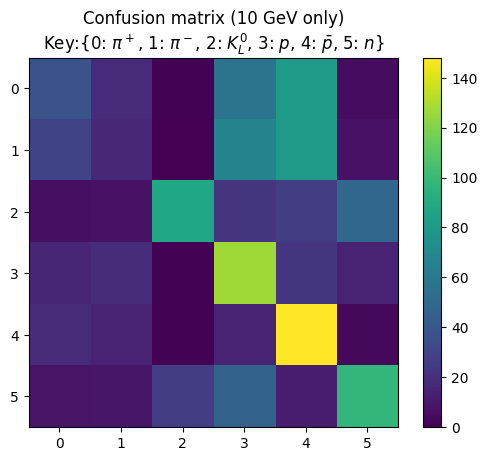

In [84]:
plt.imshow(cmat)
plt.title('Confusion matrix (10 GeV only)\n' + r'Key:{0: $\pi^+$, 1: $\pi^-$, 2: $K^0_L$, 3: $p$, 4: $\bar{p}$, 5: $n$}')
plt.colorbar()

In [43]:
maxes = np.max(yhat,axis=0)
indices = [list(yhat[:,i]).index(maxes[i]) for i in range(6)]
particle_types = ['PION','PION-','KAONLONG','PROTON','APROTON','NEUTRON']

In [44]:
indices,maxes

([419, 379, 428, 32, 1507, 424],
 array([1., 1., 1., 1., 1., 1.], dtype=float32))

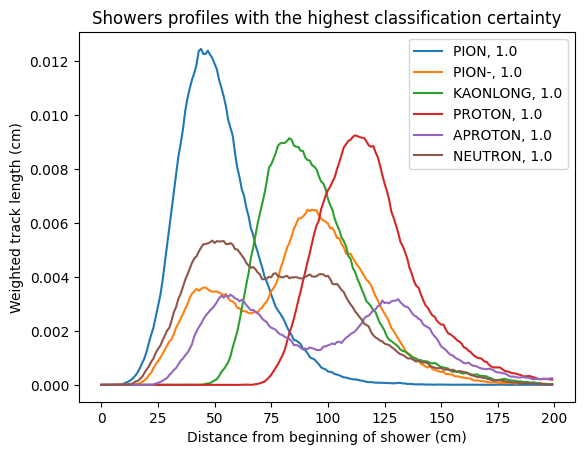

In [45]:
xvals = np.arange(500)[:200]

for i in range(len(indices)):
    plt.plot(xvals,xtest[indices[i],:200],label=particle_types[i]+', '+str(maxes[i]))
plt.legend()
plt.title('Showers profiles with the highest classification certainty')
plt.xlabel('Distance from beginning of shower (cm)')
plt.ylabel('Weighted track length (cm)')
plt.show()

In [47]:
typeNum=0
indexes = list(range(yhat.shape[0]))
sorted_list = sorted(zip(yhat.numpy()[:,typeNum],indexes))
sorted_list.reverse()

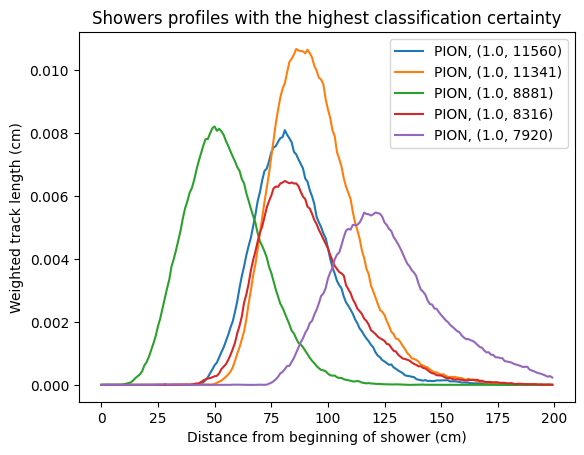

In [48]:
for i in range(5):
    plt.plot(xvals,xtest[sorted_list[i][1],:200],label=particle_types[typeNum]+', '+str(sorted_list[i]))
plt.legend()
plt.title('Showers profiles with the highest classification certainty')
plt.xlabel('Distance from beginning of shower (cm)')
plt.ylabel('Weighted track length (cm)')
plt.show()

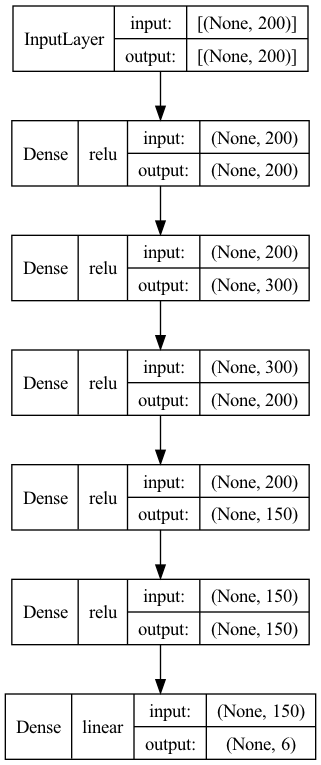

In [86]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, 
                          show_layer_activations=True)